Found 43 images belonging to 2 classes.
Found 2 images belonging to 2 classes.


c:\Users\ahmed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\ahmed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 312ms/step - accuracy: 0.5441 - loss: 0.6905 - val_accuracy: 0.5000 - val_loss: 0.6388
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.6307 - loss: 0.6589 - val_accuracy: 0.5000 - val_loss: 0.5936
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.6892 - loss: 0.5965 - val_accuracy: 1.0000 - val_loss: 0.5003
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.5545 - loss: 0.6742 - val_accuracy: 1.0000 - val_loss: 0.4247
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.7359 - loss: 0.5308 - val_accuracy: 1.0000 - val_loss: 0.3809
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.7461 - loss: 0.5602 - val_accuracy: 1.0000 - val_loss: 0.2797
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.8394 - loss: 0.4414 - val_accuracy: 1.0000 - val_loss: 0.2100
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.8464 - loss: 0.3883 - val_accuracy: 1.0000 - val_loss: 

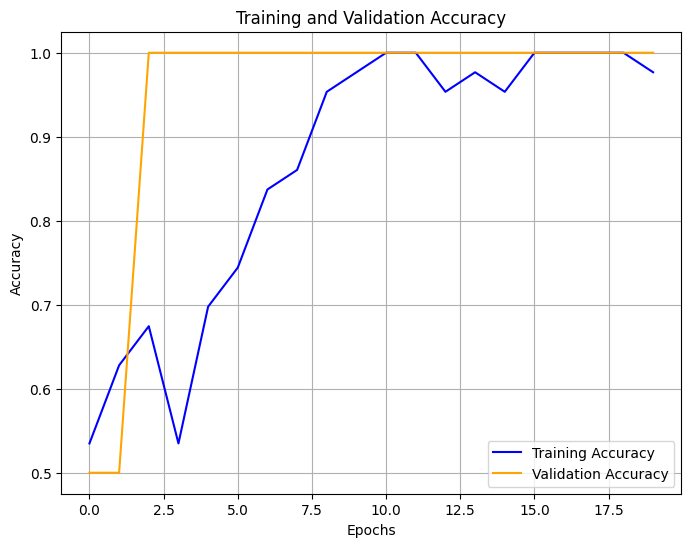

In [ ]:
#import libraries
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data preparation
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_data = datagen.flow_from_directory('C:/Users/ahmed/Downloads/project/train', target_size=(64, 64), batch_size=32, subset='training', class_mode='categorical')
val_data = datagen.flow_from_directory('C:/Users/ahmed/Downloads/project/test', target_size=(64, 64), batch_size=32, subset='validation', class_mode='categorical')


# Model definition
model_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')
])


# Compilation
model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training
history = model_cnn.fit(train_data, validation_data=val_data, epochs=20)


# Plot Accuracy Graph
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#import libraries
import cv2
import numpy as np
import serial
import time
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet50 import preprocess_input


# Define labels
labels = {0: 'Apple', 1: 'Banana'}
# Serial communication
arduino = serial.Serial('COM5', 9600, timeout=1)

def capture_and_predict():
    # Open the webcam
    cap = cv2.VideoCapture(0)

    if not cap.isOpened():
        print("Error: Could not access the camera.")
        return

    print("Press 'c' to capture an image and predict, or 'q' to quit.")
    while True:
        # Capture frame-by-frame
        ret, frame = cap.read()
        if not ret:
            print("Error: Failed to capture image.")
            break

        # Display the frame
        cv2.imshow("Camera", frame)

        # Wait for key press
        key = cv2.waitKey(1)
        if key & 0xFF == ord('c'):
            # Process the captured image
            prediction = predict_image(frame)
            print(f"Predicted Type: {prediction}")
            send_prediction_to_arduino(prediction)
        elif key & 0xFF == ord('q'):
            break

    # Release the webcam and close windows
    cap.release()
    cv2.destroyAllWindows()

def predict_image(image):
    # Resize the image to match ResNet50 input size
    resized_image = cv2.resize(image, (64, 64))  # Resize to 224x224 for ResNet50
    # Convert the image to a NumPy array and expand dimensions
    img_array = np.expand_dims(resized_image, axis=0)
    # Preprocess the image for ResNet50
    preprocessed_image = preprocess_input(img_array)

    # Predict using the model
    predictions = model_cnn.predict(preprocessed_image)
    predicted_class = np.argmax(predictions, axis=1)[0]

    # Map the prediction to the label
    return predictions  # Returns predictions as an array, e.g., [[0.1, 0.9]]

def send_prediction_to_arduino(prediction):
    """
    Sends the prediction to Arduino via serial communication.
    :param prediction: The model's prediction (probabilities for 'Apple' and 'Banana')
    """
    # Extract the probabilities for Apple and Banana
    apple_prob = prediction[0][0]  # First element: Apple probability
    banana_prob = prediction[0][1]  # Second element: Banana probability

    # Send the result to the Arduino (1 for Apple, 0 for Banana)
    if apple_prob > banana_prob:
        arduino.write(b'1')  # Apple: Rotate 90 degrees clockwise
        print("Rotating servo 90 degrees clockwise for Apple.")
    else:
        arduino.write(b'0')  # Banana: Rotate 90 degrees counter-clockwise
        print("Rotating servo 90 degrees counter-clockwise for Banana.")

if __name__ == "__main__":
    capture_and_predict()




Press 'c' to capture an image and predict, or 'q' to quit.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Predicted Type: [[1. 0.]]
Rotating servo 90 degrees clockwise for Apple.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Predicted Type: [[1.0000000e+00 6.0889535e-16]]
Rotating servo 90 degrees clockwise for Apple.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted Type: [[1. 0.]]
Rotating servo 90 degrees clockwise for Apple.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Predicted Type: [[1. 0.]]
Rotating servo 90 degrees clockwise for Apple.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Predicted Type: [[1. 0.]]
Rotating servo 90 degrees clockwise for Apple.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted Type: [[0. 1.]]
Rotating servo 90 degrees counter-clockwise for Banana.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Predicted Type: [[1. 0.]]
Rotating servo 90 degrees clockwise for Apple.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted Type: [[0. 1.]]
Rotating servo 90 degrees counter-clockwise for Banana.
1/1 ━━━━━━━━━